# Approximating likelihood ratios with calibrated classifiers

Gilles Louppe, January 2016.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

## Toy problem

Let us consider two 1D distributions $p_0$ and $p_1$ for which we want to approximate the ratio $r(x) = \frac{p_0(x)}{p_1(x)}$ of their densities.

- $p_1$ is defined as a mixture of two gaussians;
- $p_0$ is defined as a mixture of the same two gaussians + a bump.

In [2]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75),   # c0
    Normal(mu=0.0, sigma=2.0),     # c1
    Normal(mu=1.0, sigma=0.5)      # c2 (bump)
]

bump_coefficient = 0.05
g = theano.shared(bump_coefficient) 
p0 = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g])
p1 = Mixture(components=components[:2], weights=[0.5, 0.5])

Note: for $p_0$, weights are all tied together through the Theano shared variable `g`. This means that changes to the value stored in `g` also automatically change the weight values and the resulting mixture.

In [3]:
X_true = p0.rvs(5000, random_state=777)

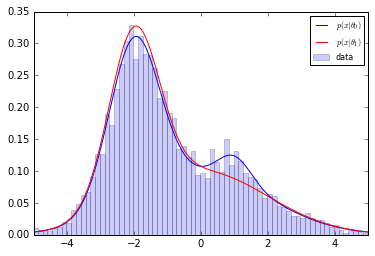

In [4]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_0)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_1)$", color="r")
plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

## Density ratio estimation

The density ratio $r(x)$ can be approximated using calibrated classifiers, either directly by learning to classify $x \sim p_0$ from $x \sim p_1$, or by decomposing the ratio of the two mixtures as pairs of simpler density ratios.

In [5]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV
from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV

# clf = ElasticNetCV()  # use 100 and 50 bins
clf = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)  # use 15 and 12 bins
# clf = ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)  # use 15 and 15 bins

n_samples = 200000

# No calibration
cc_none = ClassifierRatio(base_estimator=clf, random_state=1)
cc_none.fit(numerator=p0, denominator=p1, n_samples=n_samples)

# Calibration + Direct approximation 
cv = StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)
cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=15, cv=cv), 
    random_state=0)
cc_direct.fit(numerator=p0, denominator=p1, n_samples=n_samples)

# Calibration + Decomposition of the mixture
cc_decomposed = DecomposedRatio(ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=12, cv=cv), 
    random_state=0))
cc_decomposed.fit(numerator=p0, denominator=p1, n_samples=n_samples)

DecomposedRatio(base_ratio=ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=...andom_state=1, test_size=0.5,
            train_size=None),
            eps=0.1, method='histogram'),
        random_state=0))

Note: `CalibratedClassifierRatio` takes three arguments for controlling its execution:
- `base_estimator` specifying the classifier to be used,
- `calibration` specifying the calibration algorithm (`"kde"`, `"histogram"`, or a user-defined distribution-like object),
- `cv` specifying how to allocate data for training and calibration.

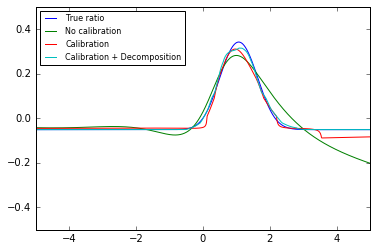

In [6]:
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")

plt.plot(reals, cc_none.predict(reals.reshape(-1, 1), log=True), label="No calibration")
plt.plot(reals, cc_direct.predict(reals.reshape(-1, 1), log=True), label="Calibration")
plt.plot(reals, cc_decomposed.predict(reals.reshape(-1, 1), log=True), label="Calibration + Decomposition")

plt.xlim(-5, 5)
plt.ylim(-0.5, 0.5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

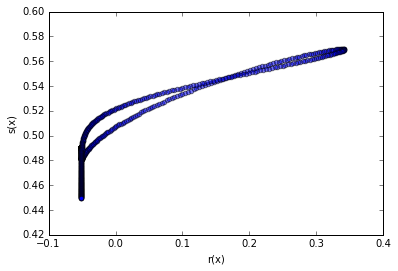

In [7]:
plt.scatter(-p0.nnlf(reals.reshape(-1, 1)) + p1.nnlf(reals.reshape(-1, 1)), 
            cc_none.classifier_.predict_proba(reals.reshape(-1, 1))[:, 0], alpha=0.5)
plt.xlabel("r(x)")
plt.ylabel("s(x)")

## Using density ratios for maximum likelihood fit

In [8]:
def nll_true(theta, X):
    g.set_value(theta[0])
    return (p0.nnlf(X) - p1.nnlf(X)).sum()

def nll_approx(theta, X):
    g.set_value(theta[0])
    return -np.sum(cc_decomposed.predict(X, log=True))

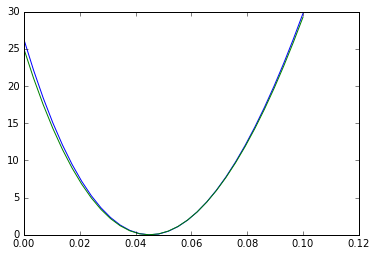

In [9]:
g_scan = np.linspace(0.0, 2 * bump_coefficient,30)
nll_true_scan = np.array([nll_true([t], X_true) for t in g_scan])
nll_approx_scan = np.array([nll_approx([t], X_true) for t in g_scan])
plt.plot(g_scan, nll_true_scan-nll_true_scan.min())
plt.plot(g_scan, nll_approx_scan-nll_approx_scan.min())

In [10]:
from sklearn.utils import check_random_state
from scipy.optimize import minimize

n_trials = 1000

true_mles = []
true_nll = []
approx_mles = []
approx_nll = []

for i in range(n_trials):        
    # Generate new data
    g.set_value(bump_coefficient)
    X_true = p0.rvs(5000, random_state=i)
    
    # True MLE
    results = minimize(nll_true, x0=[0.1], args=(X_true,),
                       constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                    {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

    true_mles.append(results.x[0])
    true_nll.append(2. * (nll_true([bump_coefficient], X_true) - results.fun))
    
    # Inference with ratios
    results = minimize(nll_approx, x0=[0.1], args=(X_true,),
                       constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                    {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

    approx_mles.append(results.x[0])
    approx_nll.append(2. * (nll_approx([bump_coefficient], X_true) - results.fun))

In [11]:
true_mles = np.array(true_mles)
true_mles = true_mles[np.isfinite(true_mles)]
approx_mles = np.array(approx_mles)
approx_mles = approx_mles[np.isfinite(approx_mles)]
np.mean(true_mles), np.mean(approx_mles)

(0.050114731275088642, 0.050036546936300573)

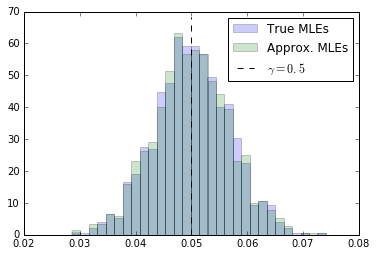

In [12]:
h = plt.hist(true_mles, bins=30, normed=1, alpha=0.2, color="b", label="True MLEs")
h = plt.hist(approx_mles, bins=30, normed=1, alpha=0.2, color="g", label="Approx. MLEs")
plt.vlines(bump_coefficient, 0, h[0].max()+5, linestyles="dashed", label=r"$\gamma = 0.5$")
plt.legend()
plt.show()

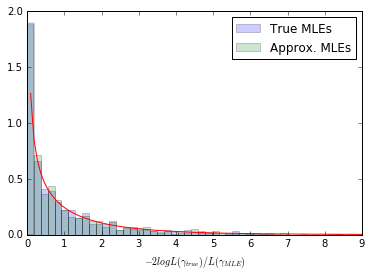

In [13]:
from scipy.stats import chi2

bins = np.linspace(0, 9, 50)
test = np.linspace(0, 9, 100)
true_counts, _, _ = plt.hist(2 * true_nll, bins=bins, normed=1, alpha=0.2, label="True MLEs")
approx_counts, _, _ = plt.hist(2 * approx_nll, bins=bins, normed=1, alpha=0.2, label="Approx. MLEs")
plt.plot(test, chi2.pdf(test, df=1))
plt.legend()
plt.xlabel(r"$-2 log L(\gamma_{true}) / L(\gamma_{MLE})$")

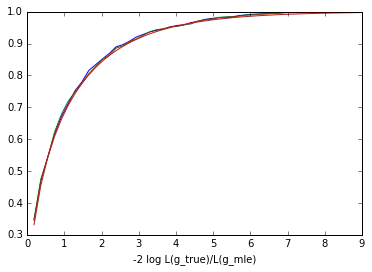

In [14]:
plt.plot(bins[1:], np.cumsum(true_counts) * (bins[1]-bins[0]), c="b")
plt.plot(bins[1:], np.cumsum(approx_counts) * (bins[1]-bins[0]), c="g")
plt.plot(bins[1:], chi2.cdf(bins[1:], df=1), c="r")
plt.xlabel("-2 log L(g_true)/L(g_mle)")

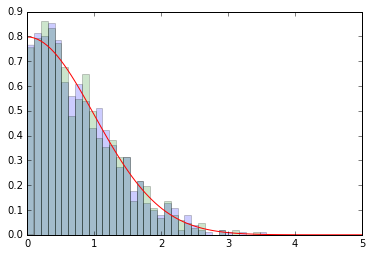

In [15]:
from scipy.stats import norm 

bins = np.linspace(0, 5, 50)
test = np.linspace(0, 5, 100)
counts, bins, patches = plt.hist(np.sqrt(2 * true_nll), bins=bins, normed=1, alpha=0.2, color="b")
counts, bins, patches = plt.hist(np.sqrt(2 * approx_nll), bins=bins, normed=1, alpha=0.2, color="g")
plt.plot(test, 2 * norm.pdf(test), c="r")